In [1]:
import os
import numpy as np

from keras.layers import Dense, Input, Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose

from keras.models import Model
from keras import backend as K

from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

from keras.datasets import cifar10
from keras.utils import plot_model

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

Using TensorFlow backend.


In [0]:
# Define a func to get a gray-scale image
def get_gray(data):
    return data[..., :3].dot([.299, .587, .114]) 

In [0]:
def normalize_it(images):
    return images.astype('float32') / 255

# Colouring autoencoder with Keras

## Load, examine & transform the data

In [0]:
(X_train, _), (X_test, _) = cifar10.load_data()

In [5]:
# Check dimensions
X_train.shape

(50000, 32, 32, 3)

In [0]:
# Get dimensions
img_rows = X_train.shape[1]
img_cols = X_train.shape[2]
channels = X_train.shape[3]

* ### Convert imgs to grayscale

In [0]:
X_train_gray = get_gray(X_train)
X_test_gray = get_gray(X_test)

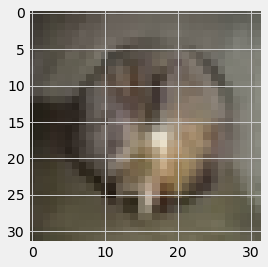

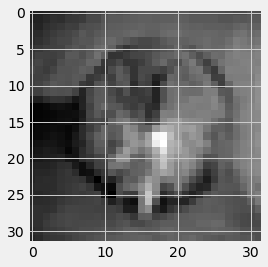

In [8]:
pic_no = np.random.randint(X_test.shape[0])

plt.imshow(X_test[pic_no].squeeze())
plt.show()

plt.imshow(X_test_gray[pic_no].squeeze(), 
           cmap = 'gray')
plt.show()

In [0]:
# Normalize the data
X_train = normalize_it(X_train)
X_test = normalize_it(X_test)

## Define network params

In [0]:
# Reshape the data
X_train = X_train.reshape(X_train.shape[0], 
                          img_rows, 
                          img_cols, 
                          channels)

X_test = X_test.reshape(X_test.shape[0], 
                          img_rows, 
                          img_cols, 
                          channels)


X_train_gray = X_train_gray.reshape(X_train_gray.shape[0], 
                                    img_rows, 
                                    img_cols, 
                                    1)

X_test_gray = X_test_gray.reshape(X_test_gray.shape[0], 
                                  img_rows, 
                                  img_cols, 
                                  1)

In [0]:
input_shape = (img_rows, img_cols, 1)
batch_size = 32
kernel_size = 3
latent_dim = 256
layer_filters = [64, 128, 256]

## Build the model

* ### Encoder

In [12]:
inputs = Input(shape = input_shape, 
               name  = 'encoder_input')

x = inputs

W0621 14:18:54.843716 140615524804480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



In [13]:
# Create a stack of Conv2Ds

for filters in layer_filters:
    x = Conv2D(filters     = filters,
               kernel_size = kernel_size,
               strides     = 2, 
               activation  = 'relu',
               padding     = 'same')(x)

W0621 14:18:54.878050 140615524804480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0621 14:18:54.883251 140615524804480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [0]:
# Get the last layer's shape
enc_out_shape = K.int_shape(x)

In [0]:
# Create a latent vector
x = Flatten()(x)

latent = Dense(latent_dim, 
               name = 'latent_vector')(x)

In [0]:
# Instantiate the encoder
encoder = Model(inputs, latent,
                name = 'encoder')

In [17]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 256)               1048832   
Total params: 1,418,496
Trainable params: 1,418,496
Non-trainable params: 0
_________________________________________________________________


* ### Decoder

In [0]:
latent_inputs = Input(shape = (latent_dim,), 
                      name  = 'decoder_input')

In [0]:
x = Dense(enc_out_shape[1] * enc_out_shape[2] * enc_out_shape[3])(latent_inputs)

x = Reshape((enc_out_shape[1], 
             enc_out_shape[2], 
             enc_out_shape[3]))(x)

In [0]:
# Construct a stack of Conv2DTranspose
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters     = filters, 
                        kernel_size = kernel_size,
                        strides     = 2,
                        activation  = 'relu', 
                        padding     = 'same')(x)

In [0]:
outputs = Conv2DTranspose(filters     = channels, 
                          kernel_size = kernel_size,
                          activation  = 'sigmoid', 
                          padding     = 'same', 
                          name        = 'decoder_output')(x)

In [0]:
# Instantiate the decoder
decoder = Model(latent_inputs, outputs,
                name = 'decoder')

In [23]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              1052672   
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         590080    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 128)       295040    
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 64)        73792     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 32, 32, 3)         1731      
Total para

* ### Autoencoder

In [0]:
# Instantiate
autoencoder = Model(inputs, decoder(encoder(inputs)),
                    name = 'autoencoder')

In [25]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 32, 32, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 256)               1418496   
_________________________________________________________________
decoder (Model)              (None, 32, 32, 3)         2013315   
Total params: 3,431,811
Trainable params: 3,431,811
Non-trainable params: 0
_________________________________________________________________


* ### Model saving params

In [0]:
# Define file names / dirs
save_dir = '03_saved_models'
model_name = 'colorizer_ae_{epoch:03d}.h5'

In [0]:
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

* ### Define callbacks

In [0]:
# Reduce LR by sqrt(.1) if loss does not improve in 5 epochs
lr_reducer = ReduceLROnPlateau(factor   = np.sqrt(.1), 
                               cooldown = 0,
                               patience = 5,
                               verbose  = 1, 
                               min_lr   = 0.5e-6)

In [0]:
# Save chackpoint
checkpoint = ModelCheckpoint(filepath       = filepath, 
                             monitor        = 'val_loss',
                             verbose        = 1,
                             save_best_only = True)

* ### Compile & train the model 

In [30]:
# Compile 
autoencoder.compile(loss      = 'mse',
                    optimizer = 'adam')

W0621 14:19:11.480945 140615524804480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
# Define callbacks
callbacks = [lr_reducer, checkpoint]

In [32]:
# Train
autoencoder.fit(X_train_gray, X_train,
                validation_data = (X_test_gray, X_test),
                epochs          = 15,
                batch_size      = batch_size,
                callbacks       = callbacks)

W0621 14:19:15.606833 140615524804480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0621 14:19:15.814341 140615524804480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 23s 459us/step - loss: 0.0155 - val_loss: 0.0115

Epoch 00001: val_loss improved from inf to 0.01146, saving model to 03_saved_models/colorizer_ae_001.h5
Epoch 2/15
50000/50000 [==============================] - 20s 394us/step - loss: 0.0103 - val_loss: 0.0098

Epoch 00002: val_loss improved from 0.01146 to 0.00980, saving model to 03_saved_models/colorizer_ae_002.h5
Epoch 3/15
50000/50000 [==============================] - 20s 392us/step - loss: 0.0094 - val_loss: 0.0092

Epoch 00003: val_loss improved from 0.00980 to 0.00918, saving model to 03_saved_models/colorizer_ae_003.h5
Epoch 4/15
50000/50000 [==============================] - 20s 394us/step - loss: 0.0089 - val_loss: 0.0098

Epoch 00004: val_loss did not improve from 0.00918
Epoch 5/15
50000/50000 [==============================] - 20s 394us/step - loss: 0.0086 - val_loss: 0.0096

Epoch 00005: val_loss did not improve f

In [0]:
# Get predictions
pred = autoencoder.predict(X_test_gray)

Let's see how it works...

This is the original image:


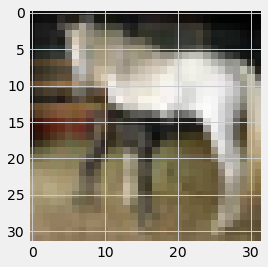



This is the gray-scale image:


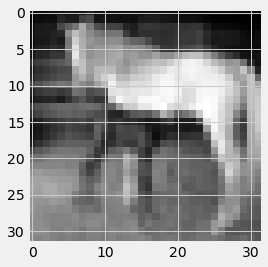



This is the coloured image:


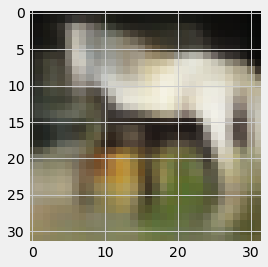

In [36]:
random_pic = np.random.randint(X_test.shape[0])
print("Let's see how it works...\n")
print("This is the original image:")
plt.imshow(X_test[random_pic].squeeze())
plt.show()
print("\n\nThis is the gray-scale image:")
plt.imshow(X_test_gray[random_pic].squeeze(), cmap='gray')
plt.show()
print("\n\nThis is the coloured image:")
plt.imshow(pred[random_pic].squeeze())
plt.show()

Let's see how it works...

This is the original image:


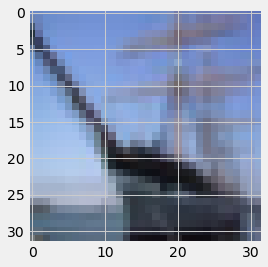



This is the gray-scale image:


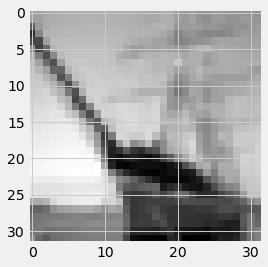



This is the coloured image:


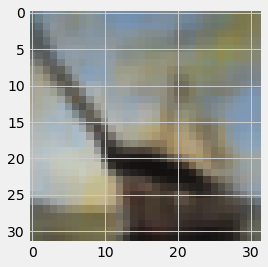

In [37]:
random_pic = np.random.randint(X_test.shape[0])
print("Let's see how it works...\n")
print("This is the original image:")
plt.imshow(X_test[random_pic].squeeze())
plt.show()
print("\n\nThis is the gray-scale image:")
plt.imshow(X_test_gray[random_pic].squeeze(), cmap='gray')
plt.show()
print("\n\nThis is the coloured image:")
plt.imshow(pred[random_pic].squeeze())
plt.show()